<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/04_going_classy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Going Classy

In this notebook, I will stick with a simple and familiar problem:
a linear regression with a single feature x! It doesn’t get much simpler than that…

$$ y = b + wx + ϵ$$

It is also possible to think of it as the simplest neural network possible: one input,
one output, and no activation function (that is, linear).

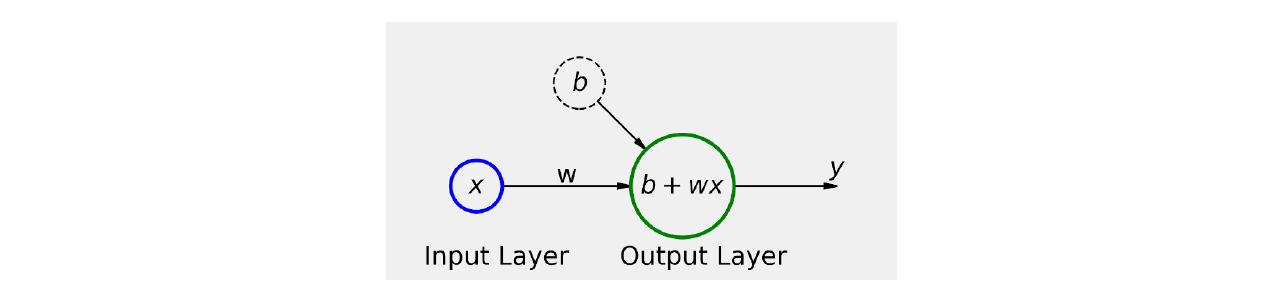

##Setup

In [1]:
try:
  import google.colab
  import requests
  url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
  r = requests.get(url, allow_redirects=True)
  open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
  pass

from config import *
config_chapter2_1()
# This is needed to render the plots in this chapter
from plots.chapter2_1 import *

Finished!


In [2]:
import numpy as np
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

##Data Generation

Let’s start generating some synthetic data: we start with a vector of `100 (N)` points
for our feature `(x)` and create our labels `(y)` using `b = 1, w = 2`, and some Gaussian noise (epsilon).

In [4]:
np.random.seed(42)

true_b = 1
true_w = 2
N = 100

# Data Generation
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.rand(N, 1))
y = true_b + true_w * x + epsilon

Next, let's split our synthetic data into train and validation sets, shuffling the array
of indexes and using the first 80 shuffled points for training.

In [5]:
# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N * .8)]
# Uses the remaining indices for validation
val_idx = idx[int(N * .8): ]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

##Linear Regression Class

Let’s start defining our class, we’re
starting it from scratch: either we don’t specify a parent class, or we inherit it from
the fundamental object class.

In [6]:
# A completely empty (and useless) class
class LinearRegression(object):
  pass

###Constructor

The constructor defines the parts that make up the class. These parts are the
attributes of the class. 

Typical attributes include:

* Arguments-needs to be specified by the user
* Placeholders- tackle the delayed arguments
* Variables-
* Functions


**Arguments**

Let’s start with the arguments, the part that needs to be specified by the user.

So, these three elements, optimizer, loss, and model, will be our main arguments.

In [7]:
class LinearRegression(object):
  def __init__(self, model, loss_fn, optimizer):
    # Here we define the attributes of our class 
    # We start by storing the arguments as attributes to use them later
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = "cuda" if torch.device.is_available() else "cpu"
    # Let's send the model to the specified device right away
    self.model.to(self.device)

  def to(self, device):
    """
    This method allows the user to specify a different device
    It sets the corresponding attribute (to be used later in
    the mini-batches) and sends the model to the device
    """
    try:
      self.device = device 
      self.model.to(self.device)
    except RuntimeError:
      self.device = "cuda" if torch.device.is_available() else "cpu"
      print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
      self.model.to(self.device)

**Placeholders**

Next, let’s tackle the placeholders or delayed arguments. We expect the user to eventually provide some of those, as they are not necessarily required.

In [8]:
class LinearRegression(object):
  def __init__(self, model, loss_fn, optimizer):
    # Here we define the attributes of our class 
    # We start by storing the arguments as attributes to use them later
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = "cuda" if torch.device.is_available() else "cpu"
    # Let's send the model to the specified device right away
    self.model.to(self.device)

    # These attributes are defined here, but since they are not available at the moment of creation, we keep them None
    self.train_loader = None
    self.val_loader = None
    self.summary_writer = None

  def to(self, device):
    """
    This method allows the user to specify a different device
    It sets the corresponding attribute (to be used later in
    the mini-batches) and sends the model to the device
    """
    try:
      self.device = device 
      self.model.to(self.device)
    except RuntimeError:
      self.device = "cuda" if torch.device.is_available() else "cpu"
      print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
      self.model.to(self.device)

  def set_loaders(self, train_loader, val_loader=None):
    """
    This method allows the user to define which train_loader (and val_loader, optionally) to use
    Both loaders are then assigned to attributes of the class, So they can be referred to later
    """
    self.train_loader = train_loader 
    self.val_loader = val_loader 

  def set_tensorboard(self, name, folder="runs"):
    # This method allows the user to create a SummaryWriter to interface with TensorBoard
    suffix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    self.summary_writer = SummaryWriter(f"{folder}/{name}_{suffix}")

**Variables**

Then, there are variables we may want to keep track of. Typical examples are the
number of epochs, and the training and validation losses. These variables are likely
to be computed and updated internally by the class.

In [9]:
class LinearRegression(object):
  def __init__(self, model, loss_fn, optimizer):
    # Here we define the attributes of our class 
    # We start by storing the arguments as attributes to use them later
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = "cuda" if torch.device.is_available() else "cpu"
    # Let's send the model to the specified device right away
    self.model.to(self.device)

    # These attributes are defined here, but since they are not available at the moment of creation, we keep them None
    self.train_loader = None
    self.val_loader = None
    self.summary_writer = None

    # These attributes are going to be computed internally
    self.losses = []
    self.val_losses = []
    self.total_epochs = 0

  def to(self, device):
    """
    This method allows the user to specify a different device
    It sets the corresponding attribute (to be used later in
    the mini-batches) and sends the model to the device
    """
    try:
      self.device = device 
      self.model.to(self.device)
    except RuntimeError:
      self.device = "cuda" if torch.device.is_available() else "cpu"
      print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
      self.model.to(self.device)

  def set_loaders(self, train_loader, val_loader=None):
    """
    This method allows the user to define which train_loader (and val_loader, optionally) to use
    Both loaders are then assigned to attributes of the class, So they can be referred to later
    """
    self.train_loader = train_loader 
    self.val_loader = val_loader 

  def set_tensorboard(self, name, folder="runs"):
    # This method allows the user to create a SummaryWriter to interface with TensorBoard
    suffix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    self.summary_writer = SummaryWriter(f"{folder}/{name}_{suffix}")

**Functions**

For convenience, sometimes it is useful to create attributes that are functions,
which will be called somewhere else inside the class. 

In our case, we can create
both `train_step` and `val_step` using the higher-order functions

In [10]:
class LinearRegression(object):
  def __init__(self, model, loss_fn, optimizer):
    # Here we define the attributes of our class 
    # We start by storing the arguments as attributes to use them later
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = "cuda" if torch.device.is_available() else "cpu"
    # Let's send the model to the specified device right away
    self.model.to(self.device)

    # These attributes are defined here, but since they are not available at the moment of creation, we keep them None
    self.train_loader = None
    self.val_loader = None
    self.summary_writer = None

    # These attributes are going to be computed internally
    self.losses = []
    self.val_losses = []
    self.total_epochs = 0

    # Creates the train_step function for our model, loss function and optimizer
    # Note: there are NO ARGS there! It makes use of the class attributes directly
    self.train_step = self._make_train_step()
    self.val_step = self._make_val_step()

  def to(self, device):
    """
    This method allows the user to specify a different device
    It sets the corresponding attribute (to be used later in
    the mini-batches) and sends the model to the device
    """
    try:
      self.device = device 
      self.model.to(self.device)
    except RuntimeError:
      self.device = "cuda" if torch.device.is_available() else "cpu"
      print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
      self.model.to(self.device)

  def set_loaders(self, train_loader, val_loader=None):
    """
    This method allows the user to define which train_loader (and val_loader, optionally) to use
    Both loaders are then assigned to attributes of the class, So they can be referred to later
    """
    self.train_loader = train_loader 
    self.val_loader = val_loader 

  def set_tensorboard(self, name, folder="runs"):
    # This method allows the user to create a SummaryWriter to interface with TensorBoard
    suffix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    self.summary_writer = SummaryWriter(f"{folder}/{name}_{suffix}")

Here, both `_make_train_step` and `_make_val_step` are defined as
protected methods. I expect users not to call them directly, but if someone
decides to define a class that inherits from StepByStep, they should feel entitled to
do so.

In [11]:
# This method does not need ARGS... it can refer to the attributes: self.model, self.loss_fn and self.optimizer
def _make_train_step(self):

  # Builds function that performs a step in the train loop
  def perform_train_step(x, y):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - Computes model's predictions - forward pass
    yhat = model(x)

    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y)

    # Step 3 - Computes gradients for "b" and "w" parameters
    loss.backward()

    # Step 4 - Updates parameters using gradients and the learning rate
    optimizer.step()
    optimizer.zero_grad()

    # Returns the loss
    return loss.item()

  # Returns the function that will be called inside the train loop
  return perform_train_step


def _make_val_step(model, loss_fn):

  # Builds function that performs a step in the validation loop
  def perform_val_step(x, y):
    # Sets model to EVAL mode
    model.eval()

    # Step 1 - Computes our model's predicted output forward pass
    yhat = model(x)

    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y)

    # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
    return loss.item()

  return perform_val_step

In order to make the additions to our code visually simpler, that is, without having
to replicate the full class every time I introduce a new method, I am resorting to
something that shouldn’t be used in regular circumstances: `setattr`

In [12]:
# ATTENTION! Using SETATTR for educational purposes only :-)
setattr(LinearRegression, "_make_train_step", _make_train_step)
setattr(LinearRegression, "_make_val_step", _make_val_step)

Instead of creating an attribute or method directly in the class, as we’ve been doing
so far, it is possible to use setattr to create them dynamically.

**Mini-batch**

The next method we need to add the mini-batch loop. We need to change it a bit, though… there, both
the data loader and the step function were arguments.

In [13]:
def _mini_batch(self, validation=False):
  """
  The mini-batch can be used with both loaders 
  The argument `validation`defines which loader and corresponding step function is going to be used
  """
  if validation:
    data_loader = self.val_loader
    step_fn = self.val_step
  else:
    data_loader = self.train_loader
    step_fn = self.train_step

  if data_loader is None:
    return None

  # Once the data loader and step function, this is the same mini-batch loop we had before 
  mini_batch_losses = []
  for x_batch, y_batch in data_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    mini_batch_loss = step_fn(x_batch, y_batch)
    mini_batch_losses.append(mini_batch_loss)
  
  loss = np.mean(mini_batch_losses)
  return loss

setattr(LinearRegression, "_mini_batch", _mini_batch)

Moreover, we need to ensure the reproducibility of the training loop.

In [14]:
def set_seed(self, seed=42):
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.manual_seed(seed)
  np.random.seed(seed)

setattr(LinearRegression, "set_seed", set_seed)

###Training Methods

In [15]:
def train(self, n_epochs, seed=42):
  # To ensure reproducibility of the training process
  self.set_seed(seed)

  for epoch in range(n_epochs):
    # Keeps track of the numbers of epochs by updating the corresponding attribute
    self.total_epochs += 1

    # TRAINING
    # Performs training using mini-batches
    loss = self._mini_batch(validation=False)
    self.losses.append(loss)

    # VALIDATION - no gradients in validation to prevent gradient computation!
    with torch.no_grad():
      # Performs evaluation using mini-batches
      val_loss = self._mini_batch(validation=True)
      self.val_losses.append(val_loss)

    # If a SummaryWriter has been set...
    if self.summary_writer:
      scalars = {"training": loss}
      if val_loss is not None:
        scalars.update({"validation": val_loss})
      # Records both losses for each epoch under tag "loss"
      self.summary_writer.add_scalars(main_tag="loss",
                                      tag_scalar_dict=scalars, 
                                      global_step=epoch)
  if self.summary_writer:
    # Flushes the writer
    self.summary_writer.flush()

setattr(LinearRegression, "train", train)

###Saving and Loading Methods

The methods for saving and loading checkpoints should look like this now.

In [16]:
def save_checkpoint(self, filename):
  # Builds dictionary with all elements for resuming training
  checkpoint = {
    "epoch": self.total_epochs,
    "model_state_dict": self.model.state_dict(),
    "optimizer_state_dict": self.optimizer.state_dict(),
    "loss": self.losses,
    "val_loss": self.val_losses
  }
  torch.save(checkpoint, filename)

def load_checkpoint(self, filename):
  # load the dictionary back
  checkpoint = torch.load(filename)

  # Restore state for model and optimizer
  self.model.load_state_dict(checkpoint["model_state_dict"])
  self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

  # load everything else into their corresponding variables
  self.saved_epoch = checkpoint["epoch"]
  self.saved_losses = checkpoint["loss"]
  self.saved_val_losses = checkpoint["val_loss"]

  # always use TRAIN for resuming training
  self.model.train()

setattr(LinearRegression, "save_checkpoint", save_checkpoint)
setattr(LinearRegression, "load_checkpoint", load_checkpoint)

To make it easier for the user to make predictions
for any new data points, we will be handling all the Numpy to PyTorch back and
forth conversion inside the function.

In [17]:
def predict(self, x):
  # Set is to evaluation mode for predictions
  self.model.eval()

  # Takes aNumpy input and make it a float tensor
  x_tensor = torch.as_tensor(x).float()
  # Send input to device and uses model for prediction
  y_hat_tensor = self.model(x_tensor.to(self.device))

  # Set it back to train mode
  self.model.train()

  # Detaches it, brings it to CPU and back to Numpy
  return y_hat_tensor.detach().cpu().numpy()

setattr(LinearRegression, "predict", predict)

###Visualization Methods

Since we have kept track of both training and validation losses as attributes, let’s
build a simple plot for them:

In [18]:
def plot_losses(self):
  fig = plt.figure(figsize=(10, 4))
  plt.plot(self.losses, label="Training Loss", c="b")
  
  if self.val_loader:
    plt.plot(self.val_losses, label="Validation Loss", c="r")

  plt.yscale("log")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.tight_layout()
  return fig

setattr(LinearRegression, "plot_losses", plot_losses)

Finally, if both training loader and TensorBoard were already configured, we can
use the former to fetch a single mini-batch and the latter to build the model graph
in TensorBoard.

In [19]:
def add_graph(self):
  if self.train_loader and self.summary_writer:
    # Fetches a single mini-batch so we can use add_graph
    x_dummy, y_dummy = next(iter(self.train_loader))
    self.summary_writer.add_graph(self.model, x_dummy.to(self.device))

setattr(LinearRegression, "add_graph", add_graph)

###The Full Code

In [20]:
class LinearRegression(object):
  def __init__(self, model, loss_fn, optimizer):
    # Here we define the attributes of our class 
    # We start by storing the arguments as attributes to use them later
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    # Let's send the model to the specified device right away
    self.model.to(self.device)

    # These attributes are defined here, but since they are not available at the moment of creation, we keep them None
    self.train_loader = None
    self.val_loader = None
    self.summary_writer = None

    # These attributes are going to be computed internally
    self.losses = []
    self.val_losses = []
    self.total_epochs = 0

    # Creates the train_step function for our model, loss function and optimizer
    # Note: there are NO ARGS there! It makes use of the class attributes directly
    self.train_step = self._make_train_step()
    self.val_step = self._make_val_step()

  def to(self, device):
    """
    This method allows the user to specify a different device
    It sets the corresponding attribute (to be used later in
    the mini-batches) and sends the model to the device
    """
    try:
      self.device = device 
      self.model.to(self.device)
    except RuntimeError:
      self.device = "cuda" if torch.device.is_available() else "cpu"
      print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
      self.model.to(self.device)

  def set_loaders(self, train_loader, val_loader=None):
    """
    This method allows the user to define which train_loader (and val_loader, optionally) to use
    Both loaders are then assigned to attributes of the class, So they can be referred to later
    """
    self.train_loader = train_loader 
    self.val_loader = val_loader 

  def set_tensorboard(self, name, folder="runs"):
    # This method allows the user to create a SummaryWriter to interface with TensorBoard
    suffix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    self.summary_writer = SummaryWriter(f"{folder}/{name}_{suffix}")

  # This method does not need ARGS... it can refer to the attributes: self.model, self.loss_fn and self.optimizer
  def _make_train_step(self):
    # Builds function that performs a step in the train loop
    def perform_train_step(x, y):
      # Sets model to TRAIN mode
      model.train()

      # Step 1 - Computes model's predictions - forward pass
      yhat = model(x)

      # Step 2 - Computes the loss
      loss = loss_fn(yhat, y)

      # Step 3 - Computes gradients for "b" and "w" parameters
      loss.backward()

      # Step 4 - Updates parameters using gradients and the learning rate
      optimizer.step()
      optimizer.zero_grad()

      # Returns the loss
      return loss.item()

    # Returns the function that will be called inside the train loop
    return perform_train_step

  def _make_val_step(self):
    # Builds function that performs a step in the validation loop
    def perform_val_step(x, y):
      # Sets model to EVAL mode
      model.eval()

      # Step 1 - Computes our model's predicted output forward pass
      yhat = model(x)

      # Step 2 - Computes the loss
      loss = loss_fn(yhat, y)

      # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
      return loss.item()

    return perform_val_step

  def _mini_batch(self, validation=False):
    """
    The mini-batch can be used with both loaders 
    The argument `validation`defines which loader and corresponding step function is going to be used
    """
    if validation:
      data_loader = self.val_loader
      step_fn = self.val_step
    else:
      data_loader = self.train_loader
      step_fn = self.train_step

    if data_loader is None:
      return None

    # Once the data loader and step function, this is the same mini-batch loop we had before 
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
      x_batch = x_batch.to(self.device)
      y_batch = y_batch.to(self.device)

      mini_batch_loss = step_fn(x_batch, y_batch)
      mini_batch_losses.append(mini_batch_loss)
    
    loss = np.mean(mini_batch_losses)
    return loss

  def train(self, n_epochs, seed=42):
    # To ensure reproducibility of the training process
    self.set_seed(seed)

    for epoch in range(n_epochs):
      # Keeps track of the numbers of epochs by updating the corresponding attribute
      self.total_epochs += 1

      # TRAINING
      # Performs training using mini-batches
      loss = self._mini_batch(validation=False)
      self.losses.append(loss)

      # VALIDATION - no gradients in validation to prevent gradient computation!
      with torch.no_grad():
        # Performs evaluation using mini-batches
        val_loss = self._mini_batch(validation=True)
        self.val_losses.append(val_loss)

      # If a SummaryWriter has been set...
      if self.summary_writer:
        scalars = {"training": loss}
        if val_loss is not None:
          scalars.update({"validation": val_loss})
        # Records both losses for each epoch under tag "loss"
        self.summary_writer.add_scalars(main_tag="loss",
                                        tag_scalar_dict=scalars, 
                                        global_step=epoch)
    if self.summary_writer:
      # Flushes the writer
      self.summary_writer.flush()

  def save_checkpoint(self, filename):
    # Builds dictionary with all elements for resuming training
    checkpoint = {
      "epoch": self.total_epochs,
      "model_state_dict": self.model.state_dict(),
      "optimizer_state_dict": self.optimizer.state_dict(),
      "loss": self.losses,
      "val_loss": self.val_losses
    }
    torch.save(checkpoint, filename)

  def load_checkpoint(self, filename):
    # load the dictionary back
    checkpoint = torch.load(filename)

    # Restore state for model and optimizer
    self.model.load_state_dict(checkpoint["model_state_dict"])
    self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    # load everything else into their corresponding variables
    self.saved_epoch = checkpoint["epoch"]
    self.saved_losses = checkpoint["loss"]
    self.saved_val_losses = checkpoint["val_loss"]

    # always use TRAIN for resuming training
    self.model.train()

  def predict(self, x):
    # Set is to evaluation mode for predictions
    self.model.eval()

    # Takes aNumpy input and make it a float tensor
    x_tensor = torch.as_tensor(x).float()
    # Send input to device and uses model for prediction
    y_hat_tensor = self.model(x_tensor.to(self.device))

    # Set it back to train mode
    self.model.train()

    # Detaches it, brings it to CPU and back to Numpy
    return y_hat_tensor.detach().cpu().numpy()

  def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.losses, label="Training Loss", c="b")
    
    if self.val_loader:
      plt.plot(self.val_losses, label="Validation Loss", c="r")

    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    return fig

  def add_graph(self):
    if self.train_loader and self.summary_writer:
      # Fetches a single mini-batch so we can use add_graph
      x_dummy, y_dummy = next(iter(self.train_loader))
      self.summary_writer.add_graph(self.model, x_dummy.to(self.device))

  def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

##Classy Pipeline

But, first, let’s generate our synthetic data once again.

In [21]:
# Runs data generation - so we do not need to copy code here
%run -i data_generation/simple_linear_regression.py

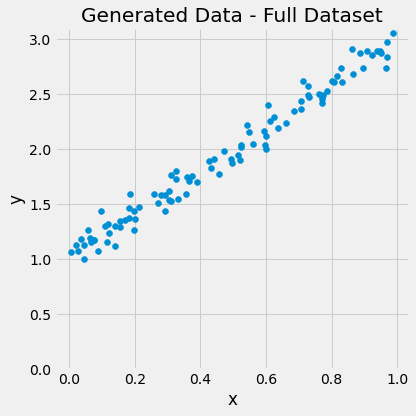

In [22]:
fig = figure1(x, y)

###Data Preparation

The first part of the pipeline is the Data Preparation. It turns out; we can still keep
it exactly the way it was.

In [23]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
# Performing train-validation split in PyTorch
train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

###Model Configuration

So, we strip the model configuration code down to its bare minimum, that is, we keep only the elements we need to pass as arguments to our LinearRegression class: model, loss function, and optimizer.

In [24]:
%%writefile model_configuration/v4.py

# Sets learning rate
lr = 0.1

torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction="mean")

Writing model_configuration/v4.py


In [25]:
%run -i model_configuration/v4.py

<Figure size 432x288 with 0 Axes>

In [26]:
# Let’s inspect the randomly initialized parameters of our model
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


###Model Training

In [27]:
# instantiating the LinearRegression class
linear_reg = LinearRegression(model, loss_fn, optimizer)
# set its loaders
linear_reg.set_loaders(train_loader, val_loader)
# set up an interface with TensorBoard
linear_reg.set_tensorboard("classy")

One important thing to notice is that the model attribute of the `linear_reg` object is the
same object as the model variable created in the model configuration.

In [28]:
print(linear_reg.model == model)
print(linear_reg.model)

True
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


Let’s train the model now, using the same 200 epochs.

In [29]:
linear_reg.train(n_epochs=200)

In [30]:
# Let’s check it out
print(model.state_dict())  # remember, model == sbs.model
print(linear_reg.total_epochs)

OrderedDict([('0.weight', tensor([[1.9416]])), ('0.bias', tensor([1.0235]))])
200


Let’s take a look at the losses.

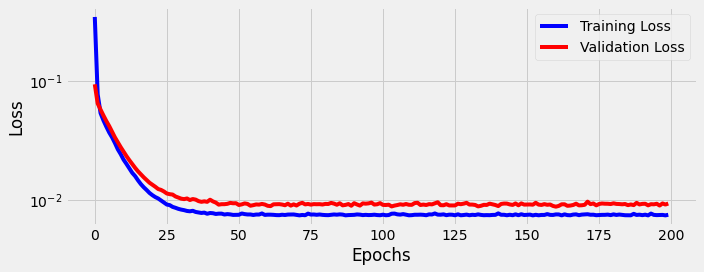

In [31]:
fig = linear_reg.plot_losses()

###Making Predictions

Let’s make up some data points for our feature x, and shape them as a single-column matrix.

In [34]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [35]:
# let's make prediction
predictions = linear_reg.predict(new_data)
predictions

array([[1.9942763],
       [1.605955 ],
       [2.3825974]], dtype=float32)

So, now let's checkpoint the model to
resume training later.

In [36]:
linear_reg.save_checkpoint("model_checkpoint.pth")

###Resuming Training

In [37]:
%run -i model_configuration/v4.py

<Figure size 432x288 with 0 Axes>

Let’s double-check that we do have an untrained model.

In [38]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


Next, let’s load the trained model back using the `load_checkpoint` method.

In [39]:
new_linear_reg = LinearRegression(model, loss_fn, optimizer)

In [40]:
new_linear_reg.load_checkpoint("model_checkpoint.pth")

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]])), ('0.bias', tensor([1.0235]))])


Great, these are the weights of our trained model. Let’s train it a bit further then…

But we are still missing one thing… the data!

In [47]:
new_linear_reg.set_loaders(train_loader, val_loader)

# train
new_linear_reg.train(n_epochs=50)

Let’s take a look at the losses.

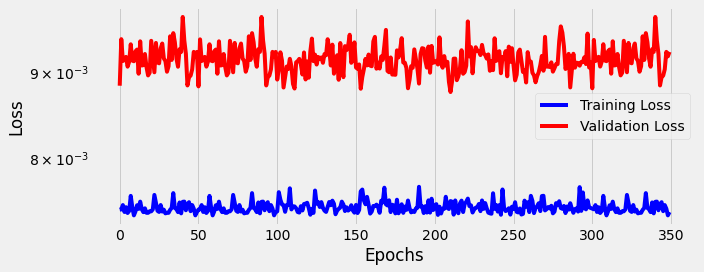

In [48]:
fig = new_linear_reg.plot_losses()

If the losses haven’t changed, it means the training loss was at a minimum already.

So, we expect the weights to remain unchanged.

In [44]:
print(new_linear_reg.model.state_dict())

OrderedDict([('0.weight', tensor([[1.9419]])), ('0.bias', tensor([1.0241]))])


No changes, indeed.

##Putting It All Together

In [49]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
# Performing train-validation split in PyTorch
train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [50]:
# %load model_configuration/v4.py

# Sets learning rate
lr = 0.1

torch.manual_seed(42)

# Now we can create a model 
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction="mean")

In [51]:
# Defines number of epochs
n_epochs = 200

final_linear_reg = LinearRegression(model, loss_fn, optimizer)
final_linear_reg.set_loaders(train_loader, val_loader)
final_linear_reg.set_tensorboard("classy")
final_linear_reg.train(n_epochs=n_epochs)

In [52]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]])), ('0.bias', tensor([1.0235]))])


Congratulations! 

You have developed a fully-functioning class that implements all
methods relevant to model training and evaluation.